## Essentia saturation detector

In [1]:
from IPython.display import Audio
from essentia.standard import MonoLoader, SaturationDetector, FrameGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
import math


test_data_path = "/home/poulpos/data/pigs/test/BOX2-FARMOTT"

[   INFO   ] MusicExtractorSVM: no classifier models were configured by default


In [2]:
sr = 44100

audio_file = os.path.join(test_data_path, "BOX2-FARMOTT_20230621_061500.wav")
audio = MonoLoader(filename=audio_file, sampleRate=sr)()
time = np.arange(len(audio)) / sr

In [3]:
frame_size = 512
hop_size = 256

saturationDetector = SaturationDetector(frameSize=frame_size,
                                        hopSize=hop_size)

starts, ends = [], []
for frame in FrameGenerator(audio,
                            frameSize=frame_size,
                            hopSize=hop_size,
                            startFromZero=True):
    frame_starts, frame_ends = saturationDetector(frame)
    starts.extend(frame_starts)
    ends.extend(frame_ends)

In [4]:
list(zip(starts,ends))[:10]

[(127.24807, 127.24814),
 (127.82853, 127.82861),
 (127.829254, 127.82952),
 (127.83184, 127.83197),
 (127.83887, 127.83889),
 (127.849884, 127.84993),
 (127.85063, 127.85068),
 (127.85361, 127.85377),
 (127.8541, 127.854126),
 (127.85449, 127.85467)]

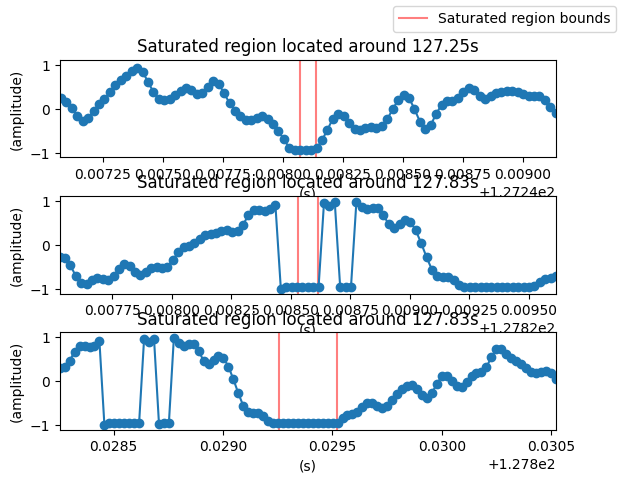

In [5]:
n = 3
fig, ax = plt.subplots(n)
plt.subplots_adjust(hspace=0.4)

for idx in range(3):
    l1 = ax[idx].axvline(starts[idx], color="r", alpha=0.5)
    ax[idx].axvline(ends[idx], color="r", alpha=0.5)
    ax[idx].plot(time, audio, marker="o")
    ax[idx].set_xlim([starts[idx] - 0.001, ends[idx] + 0.001])
    ax[idx].set_title("Saturated region located around {:.2f}s"\
        .format(np.mean([ends[idx], starts[idx]])))
    ax[idx].set_ylabel("(amplitude)")
    ax[idx].set_xlabel("(s)")

l1.set_label("Saturated region bounds")
fig.legend()

In [6]:
frame_duration = 1

ise = 0
residual = 0
n_frame = math.ceil(time[-1] / frame_duration)
rate = n_frame * [0]

for f in range(n_frame):
    current = 0
    end_frame = (f + 1) * frame_duration
    while ise < len(starts) and ends[ise] <= end_frame:
        current += ends[ise] - starts[ise]
        ise += 1
    if ise < len(starts) and starts[ise] <= end_frame:
        current += end_frame - starts[ise]
        starts[ise] = end_frame
    else:
        ise += 1
    rate[f] = current / frame_duration        

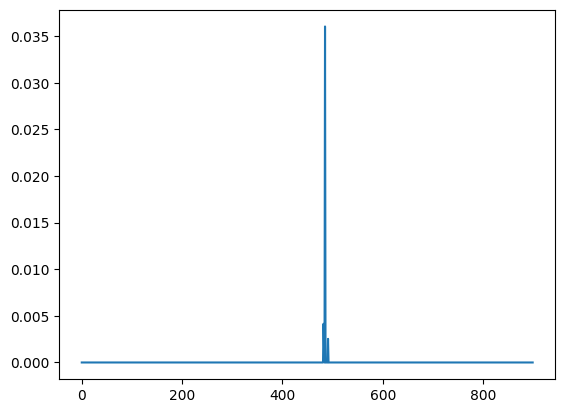

In [7]:
plt.plot(range(n_frame), rate)

In [8]:
len([r for r in rate if r > 0])

4

## Envelope (metal)

In [1]:
import soundfile as sf
import os
from scipy.signal import hilbert
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
path = "/home/poulpos/data/pigs/env"

In [3]:
metal, sr = sf.read(os.path.join(path, "metal.wav"))

In [6]:
metal += np.zeros(42)

ValueError: operands could not be broadcast together with shapes (34958,) (42,) (34958,) 

In [35]:
amp_env = np.abs(hilbert(metal, N=1000))

In [21]:
time = [i/sr*1000 for i in range(len(metal))]

ValueError: x and y must have same first dimension, but have shapes (600,) and (0,)

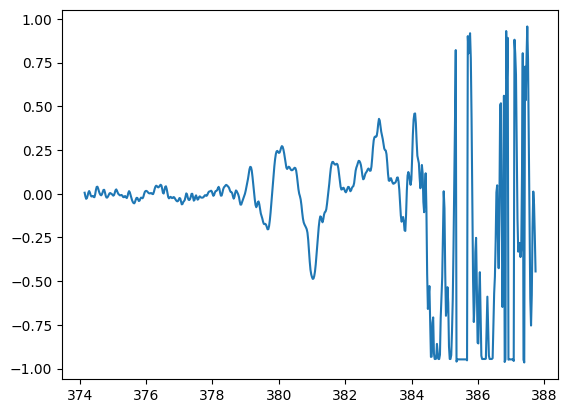

In [36]:
beg, end = 16500, 17100
fig, ax = plt.subplots()
ax.plot(time[beg:end], metal[beg:end], label='signal')
ax.plot(time[beg:end], amp_env[beg:end], label='envelope')
ax.legend()

In [27]:
len(metal)

34958

In [37]:
amp_env

array([0.0260587 , 0.00785368, 0.01738768, 0.0366155 , 0.04438304,
       0.03721203, 0.01915289, 0.00747161, 0.01991503, 0.02299168,
       0.02528628, 0.040569  , 0.0555611 , 0.05749119, 0.04359078,
       0.01712885, 0.01205446, 0.03043539, 0.0305795 , 0.01274709,
       0.02433296, 0.05330979, 0.0707458 , 0.07153256, 0.05627224,
       0.0340577 , 0.03115104, 0.05033511, 0.06743446, 0.07977515,
       0.08542976, 0.08017328, 0.06167252, 0.05135912, 0.07254923,
       0.09695083, 0.10776607, 0.1026418 , 0.09869688, 0.11272379,
       0.13512254, 0.14484579, 0.13206743, 0.10096988, 0.05919204,
       0.01746735, 0.02524934, 0.05247966, 0.07270828, 0.09051307,
       0.10635178, 0.11542748, 0.11180747, 0.09192622, 0.06560503,
       0.05408465, 0.05774693, 0.05526191, 0.03817113, 0.01755867,
       0.03568778, 0.06635985, 0.09017404, 0.10196977, 0.09866273,
       0.08304074, 0.06891859, 0.07250162, 0.08523461, 0.09225046,
       0.08447146, 0.06294282, 0.03840545, 0.02851539, 0.03259

# Pre-processing

In [ ]:
import soundfile as sf
import random
import math
import numpy as np
import glob, os

In [ ]:
def clip_and_shift(input_file, output_file, target_duration):
    with sf.SoundFile(input_file, "r") as input:
        with sf.SoundFile(output_file, "w", samplerate=input.samplerate,
                          channels=input.channels, subtype=input.subtype, endian=input.endian, format=input.format) as output:
            in_data = input.read()
            input_duration = input.frames / input.samplerate
            if input_duration == target_duration:
                out_data = in_data
            else:
                out_data = np.zeros(math.ceil(target_duration * input.samplerate), dtype=in_data.dtype)
                if input_duration < target_duration:
                    iframe_start = random.randrange(math.floor((target_duration - input_duration) * input.samplerate))
                    out_data[iframe_start:iframe_start+input.frames] = in_data
                else:
                    iframe_start = random.randrange(math.floor((input_duration - target_duration) * input.samplerate))
                    out_data = in_data[iframe_start:iframe_start+out_data.shape[0]]
            output.write(out_data)

In [ ]:
data_path = "/home/poulpos/data/pigs/test/soundwel"

In [ ]:
for i in range(1):
    for f in glob.glob("init-*.wav", root_dir=data_path):
        clip_and_shift(os.path.join(data_path, f), os.path.join(data_path, f"poueto-{f}"), 0.25)

# Tensorboard image

In [ ]:
from PIL import Image, ImageDraw, ImageFont

# get an image
with Image.open("/tmp/dessin.png").convert("RGBA") as base:

    # make a blank image for the text, initialized to transparent text color
    txt = Image.new("RGBA", base.size, (255, 255, 255, 0))

    # get a font
    #fnt = ImageFont.truetype("Pillow/Tests/fonts/FreeMono.ttf", 40)
    # get a drawing context
    d = ImageDraw.Draw(txt)

    # draw text, half opacity
    d.text((10, 10), "Hello",  fill=(255, 255, 255, 128))
    # draw text, full opacity
    d.text((10, 60), "World",  fill=(255, 255, 255, 255))

    out = Image.alpha_composite(base, txt)

    out.show()

In [ ]:
from utils.summary import prepare_img
import torch
example = torch.rand(1, 1, 128, 256)
built = prepare_img(example, num_images=1, file_names=["werwer2"])

In [ ]:
built.shape

In [ ]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.imshow(np.transpose(built, (1,2,0)), interpolation='nearest')
plt.show()

# Checkpoint

## Reset scheduler

In [3]:
import sys, os, glob
as_src_path = '/home/poulpos/pigs-documentary/as-fork/ANIMAL-SPOT'
sys.path.insert(1, as_src_path)

In [6]:
from utils.checkpoints import CheckpointHandler
from utils.logging import Logger

In [26]:
#checkpoint_dir = "/home/poulpos/pigs-documentary/rennes/2023-10-12/BOX2-FARMOTT"
    checkpoint_dir = "/home/parenaudgoud/checkpoint/BOX2-FARMOTT"
    log = Logger("TRAIN", True, "/tmp")

In [33]:
cp = CheckpointHandler(checkpoint_dir, prefix="qqqbinary_classifier", logger=log)

16:01:41|D|Starting checkpoint writer thread


In [34]:
checkpoint = cp.read_latest()

16:01:43|I|No checkpoints found in /home/poulpos/pigs-documentary/rennes/2023-10-12/BOX2-FARMOTT


In [36]:
checkpoint is None

True

In [29]:
checkpoint["trainState"]["scheduler"]['_last_lr'] = [0.001]
checkpoint["trainState"]["scheduler"]['best'] = 0
checkpoint["trainState"]["scheduler"]['num_bad_epochs'] = 0
checkpoint["trainState"]["scheduler"]['cooldown_counter'] = 0
checkpoint['trainState']['optState']['param_groups'][0]['lr'] = 0.001

In [30]:
cp.write(checkpoint)

13:49:05|D|Writing checkpoint_dict to /home/poulpos/pigs-documentary/rennes/2023-10-12/BOX2-FARMOTT/binary_classifier_epoch_00094.checkpoint


# RMS

In [3]:
import pandas as pd
df = pd.read_csv("/run/media/poulpos/PIGS-KU-BU2/chopped_farm_noise/430ms/BOX1-FARMHH/rms.csv")

In [25]:
type_count = df.groupby(['type'])['type'].count()

In [30]:
import math
import numpy as np
type_count = np.ceil(type_count / type_count.sum() * 100)

In [32]:
type_count['b'] -= 1

In [34]:
"wer".startswith("r")

False

In [36]:
import os
os.listdir(".")

['pig_recordings_protocol.odt',
 'code',
 'as-fork',
 'post-proc.ipynb',
 'publications',
 'rennes',
 'configs',
 'soundwell.ipynb',
 'preprocessing.Rmd',
 'post-proc--mikki.ipynb',
 'plot-saturation-rms.ipynb',
 'config-read.ipynb',
 'to-animal-spot.ipynb',
 'test-saturation.ipynb',
 'spectro.ipynb',
 'plot',
 'trashed.ipynb',
 'SoundwelDatasetKey.xlsx',
 'data',
 '.ipynb_checkpoints',
 'data_LFcalls_arenatest_running_2021-12-09_postPCA_oneStep.csv',
 'notes.org',
 'codes',
 'prediction.ipynb',
 'SoundwelDatasetKey.csv',
 'monitoring_recordings_blind.xlsx']

In [40]:
q = {'er': 4}

In [41]:
len(q)

1

# Time intervals

In [1]:
import pandas as pd

In [9]:
df = pd.DataFrame(data={'lab': ['wer', 'retr', 'retr', 'retr', 'wer'], 'inter': [pd.Interval(1,3), pd.Interval(0,3), pd.Interval(0,2), pd.Interval(1,2), pd.NA]})

In [10]:
df.to_csv("/tmp/inter.csv")

In [11]:
df.sort_values(by='inter')

lab   inter
2  retr  (0, 2]
1  retr  (0, 3]
3  retr  (1, 2]
0   wer  (1, 3]
4   wer    <NA>

In [16]:
df['inter'].to_xarray()

ImportError: Missing optional dependency 'xarray'.  Use pip or conda to install xarray.

In [23]:
df = pd.DataFrame(data={'lab': ['wer', 'retr', 'retr', 'retr'], 'inter': [pd.Interval(1,3), pd.Interval(0,3), pd.Interval(0,2), pd.Interval(1,2)]})

In [24]:
intervals = pd.arrays.IntervalArray(df['inter'])

In [26]:
intervals.overlaps(intervals)

NotImplementedError: 

In [27]:
df

lab   inter
0   wer  (1, 3]
1  retr  (0, 3]
2  retr  (0, 2]
3  retr  (1, 2]

In [28]:
df[[True, False, True, False]]

lab   inter
0   wer  (1, 3]
2  retr  (0, 2]

In [37]:
class Truc:
    def __init__(self):
        self.n = 0
    def get_fun(self):
        def fun(row):
            self.n += 1
            return row.lab
        return fun

In [38]:
df

lab   inter
0   wer  (1, 3]
1  retr  (0, 3]
2  retr  (0, 2]
3  retr  (1, 2]

In [39]:
t = Truc()

In [40]:
df.apply(t.get_fun(), axis=1)

0     wer
1    retr
2    retr
3    retr
dtype: object

In [41]:
t.n

4

In [42]:
df[df['lab']=='retr'][[True, False, False]]

lab   inter
1  retr  (0, 3]

In [43]:
ddf = df[df['lab']=='retr']

In [44]:
ddf

lab   inter
1  retr  (0, 3]
2  retr  (0, 2]
3  retr  (1, 2]

In [48]:
ddf.iloc[0]['lab'] = 'prout'

/tmp/ipykernel_2849/3588236589.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ddf.iloc[0]['lab'] = 'prout'


In [49]:
ddf

lab   inter
1  retr  (0, 3]
2  retr  (0, 2]
3  retr  (1, 2]

In [50]:
df

lab   inter
0   wer  (1, 3]
1  retr  (0, 3]
2  retr  (0, 2]
3  retr  (1, 2]

In [51]:
df.assign(bb=t.get_fun())

lab   inter    bb
0   wer  (1, 3]   wer
1  retr  (0, 3]  retr
2  retr  (0, 2]  retr
3  retr  (1, 2]  retr

In [54]:
t.n

5

In [55]:
df.assign(bbb=t.get_fun())

lab   inter   bbb
0   wer  (1, 3]   wer
1  retr  (0, 3]  retr
2  retr  (0, 2]  retr
3  retr  (1, 2]  retr

In [56]:
t.n

6

donc avec `apply` et pas `assign`